In [248]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [249]:
import os
import sys
import glob
import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, leastsq

### Отрисовка шаблона среднего профиля B0531+21

In [350]:
def get_value_by_bins_mjd(table, bin_size, column_name, start_mjd):# разбиение по бинам
    dect_res = {}
    bin_size = bin_size

    for idx, row in table.iterrows():
        bin_num = (float(row['MJD']) - start_mjd)//bin_size
        try:
            dect_res[bin_num].append(row[column_name])
        except KeyError:
            dect_res[bin_num] = []
            dect_res[bin_num].append(row[column_name])

    result = pd.DataFrame(columns=[
        '№ bin',
        'MJD_mean',
        'value',
    ])

    idx = 0
    for key in dect_res.keys():
        result.loc[idx] = [
            key,    
            (key + 0.5)*bin_size + start_mjd,
            np.sum(dect_res[key]),
        ]
        idx +=1

    result = result.sort_values(by=['№ bin'])
    
    return result


#  Инициализация функций 
def screan(t, t_s):
    if t < 0:
        return 0
    else:
        return np.exp(-t/t_s)


def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def my_pulse(x,a,x0,sigma, t_s):
    gs = gauss(x, a, x0, sigma)
    scr = [screan(i, t_s) for i in x] 
    return np.convolve(scr, gs, 'full')[:LEN]

In [2]:
pattern = np.genfromtxt('patterns/total_profile.txt').T

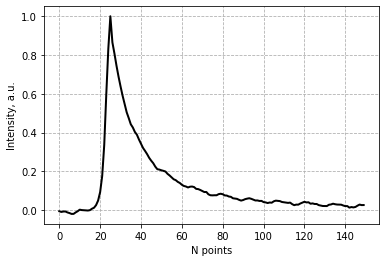

In [3]:
plt.clf()
plt.plot(pattern, 'black', lw=2)
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.grid(True, ls = '--')
plt.savefig('some_images/total_pattern.eps', format='eps')

### Отрсовка ГИ по дате и номеру 

In [348]:
date = '2015.05.19'
nomer = '0'
filename = f'results_set/file_untypized/{date}_plot_0531+21_{nomer}.csv'
pulse = np.genfromtxt(filename, skip_header=6).T

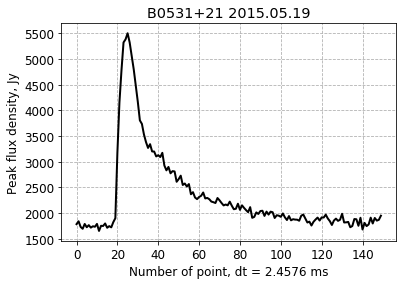

In [349]:
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.title(f'B0531+21 {date}')
plt.plot(pulse + 1720, 'black', lw=2)
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.grid(True, ls = '--')
plt.savefig('some_images/pulse_example.eps', format='eps')

In [184]:
np.max(pulse)

3781.416

### Отрисовка количества сеансов

In [311]:
crab_sessoins = pd.read_table('crab_session_kaz_2020-04-26.csv', sep='\t')

In [312]:
# Отсечка c 13.02.2010 55240.686525
# Отсечка по 25.04.2019 58598.493969
crab_sessoins = crab_sessoins[1:2005].reset_index(drop=True)

In [317]:
resul_tab_sessoins = get_value_by_bins_mjd(
    crab_sessoins, 30, 'Session', crab_sessoins['MJD'][0])

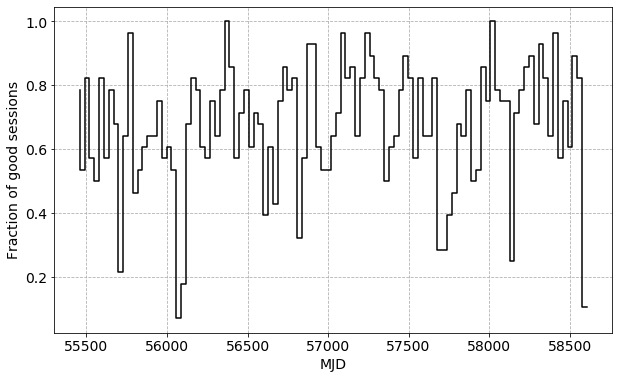

In [319]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
plt.step(resul_tab_sessoins.MJD_mean,
         resul_tab_sessoins.value/resul_tab_sessoins.value.max(), color='black')
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/sessions.eps', format='eps')

### Отрисовка выплащивания сеанса

In [2]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel


def sinxx(x):
    return (np.sin(x)/x)**2


def beam_obs(x, amp,  shift, y0):
    return amp*(np.sin(x + shift)/(x + shift))**2 + y0


if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"

elif 'Linux' in platform.platform():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"

else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

In [25]:
files_0531 = glob.glob(f'{ALL_DATA}0531+21{os.sep}*{os.sep}*{os.sep}*_profiles.txt')
print(f'Main object: 0531+21; Numbers of files: {len(files_0531)}')

# установка диапазона дат
date_start = datetime.datetime(2009, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print(f'Main set: 0531+21; Numbers of files: {len(main_set)}')

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 3040


In [26]:
date = '190515_'
file = [i for i in main_set if date in i][0]

In [27]:
head, main_pulse, data_pulses, back = read_profiles_MD(file)
day, month, year = head['date'].split('.')
            
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

obspoints = fullpoints - int(head['numpointwin'])

y = sinxx(x[:obspoints])
x = x[:obspoints]

poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

beam_coeff = beam_obs(x,*popt)
coeff = 1720/(amp - popt[2])
obser_calib = coeff*obser
y0_back = popt[2]*coeff

cor_d = []
for data_point, coeff in zip(obser_calib, beam_coeff/np.max(beam_coeff)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)
cor_d -= y0_back

poli_13 = flatter(cor_d, 13)
flat_obser = (cor_d - poli_13) + np.median(cor_d)  # Калибровка
med_flat_obser = np.median(flat_obser)

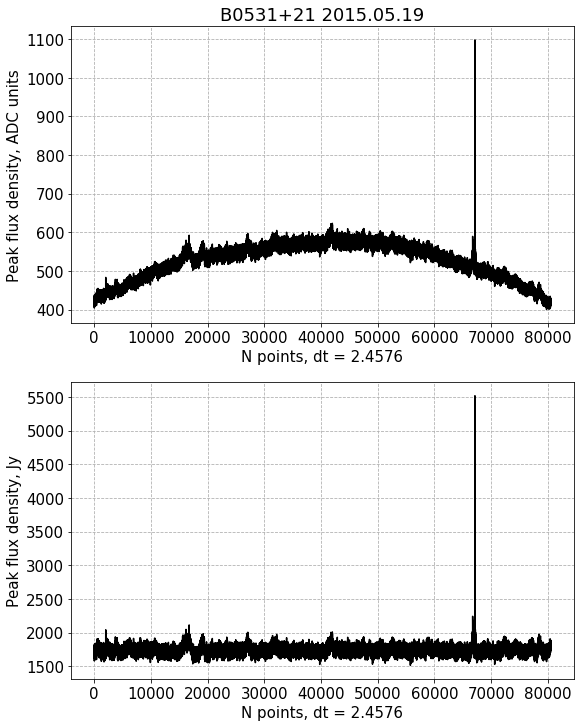

In [28]:
plt.close()
plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.title(f'B0531+21 {year}.{month}.{day}')
plt.plot(obser, color='black')
plt.grid(True, ls='--')
plt.ylabel('Peak flux density, ADC units')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.subplot(212)
plt.plot(flat_obser, color='black')
plt.ylabel('Peak flux density, Jy')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.grid(True, ls='--')
plt.savefig('some_images/one_session.eps', format='eps')

### Отрисовка темпа генерации

In [320]:
gp_table = pd.read_csv('crab_gp_kaz_pulses_2020-04-26.csv', sep='\t')

In [321]:
gp_table['gp'] = 1
start_mjd = gp_table['MJD'][0]

In [322]:
gp_table.head()

,Date,Time start,MJD,"Median, Jy","amp of gp, Jy","W50, point","W10, point","W50_19D_poly, point","W10_19D_poly, point","W50_fit_func, point","W10_fit_func, point","E_19D_poly, Jy*ms","E_fit_func, Jy*ms","Tay, ms","STD, Jy",gp
0,13.02.2010,20:26:28.9413394,55240.686525,1744.818640,269.376400,8.41850,63.16855,33.3888,64.1284,44.4222,138.0914,32034.832898,28898.736309,2.4576,42.117403,1
1,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,176.650285,17.00090,30.15760,34.3582,80.6304,25.2044,76.9230,21617.568980,12872.655848,2.4576,36.229961,1
2,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,158.318875,8.15030,39.28385,32.4268,68.7682,41.2328,128.1532,18285.165509,15387.322604,2.4576,36.229961,1
3,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,411.753190,11.70395,49.80325,22.0594,132.5044,23.8058,72.8308,32351.377388,28987.203750,2.4576,41.160847,1
4,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,228.012950,2.10090,32.54905,22.5034,129.2706,55.7368,137.2626,18275.520758,22147.841116,2.4576,41.160847,1


In [323]:
# Отсечка c 13.02.2010 55240.686525
# Отсечка по 25.04.2019 58598.493969
gp_table = gp_table[1:8754].reset_index(drop=True)

In [324]:
resul_gp = get_value_by_bins_mjd(gp_table, 30, 'gp', start_mjd)
cut_session = get_value_by_bins_mjd(crab_sessoins, 30, 'Session', start_mjd)

In [325]:
rate = pd.merge(
        resul_gp, cut_session, on='MJD_mean', how='outer', suffixes=('_gp', '_session'))
rate.where(~np.isnan(rate), other = None, inplace = True)
rate['time_obs'] = rate.value_session*3.3841152
rate['rate'] = rate.value_gp/rate.time_obs

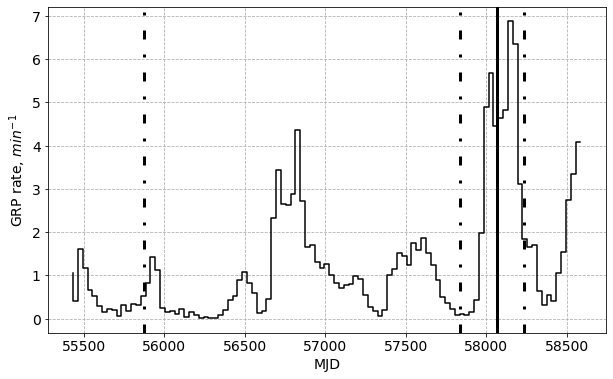

In [326]:
plt.figure(figsize=(10,6))
plt.step(rate.MJD_mean, rate.rate, color='black')
plt.ylabel(r'GRP rate, $min^{-1}$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate.eps', format='eps')

### Отрисовка логарифма пиковой плотности потока по регионам

### Отрисовка энергии по регионам c отсечкой по энергии

In [327]:
gp_table_cut_E = gp_table[gp_table['E_fit_func, Jy*ms'] > 50_000]
resul_gp_cut_E = get_value_by_bins_mjd(gp_table_cut_E, 30, 'gp', start_mjd)
cut_session = get_value_by_bins_mjd(crab_sessoins, 30, 'Session', start_mjd)

rate_cut_E = pd.merge(
        resul_gp_cut_E, cut_session, on='MJD_mean', how='outer', suffixes=('_gp', '_session'))
rate_cut_E.where(~np.isnan(rate_cut_E), other = None, inplace = True)
rate_cut_E['time_obs'] = rate_cut_E.value_session*3.3841152
rate_cut_E['rate'] = rate_cut_E.value_gp/rate_cut_E.time_obs

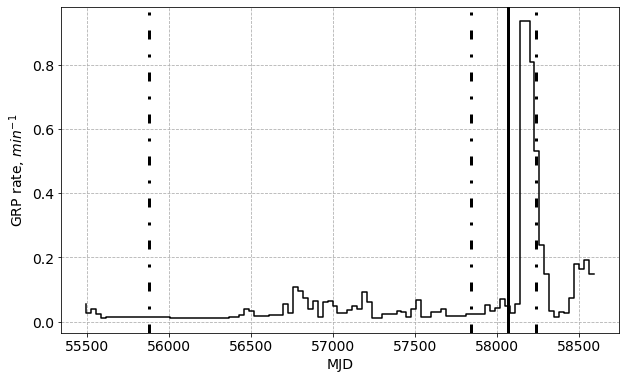

In [328]:
plt.figure(figsize=(10,6))
plt.step(rate_cut_E.MJD_mean, rate_cut_E.rate, color='black')
plt.ylabel(r'GRP rate, $min^{-1}$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E.eps', format='eps')

### Отрисовка логарифма потока и энергии за все дни

<Figure size 432x288 with 0 Axes>

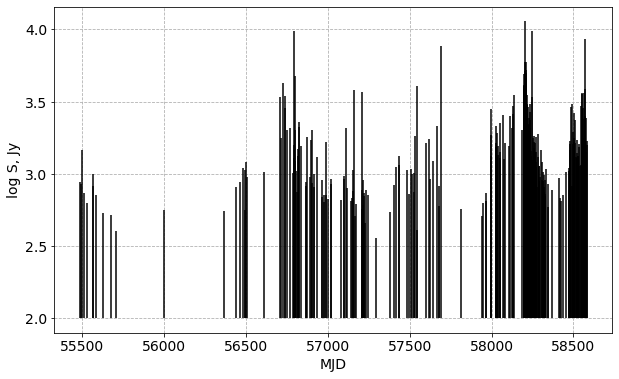

In [329]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log S, Jy')
plt.xlabel('MJD')
plt.vlines(gp_table_cut_E['MJD'], [2], np.log10(gp_table_cut_E['amp of gp, Jy']))
plt.grid(True, ls='--')
plt.savefig('some_images/flux_cut_E.eps', format='eps')

<Figure size 432x288 with 0 Axes>

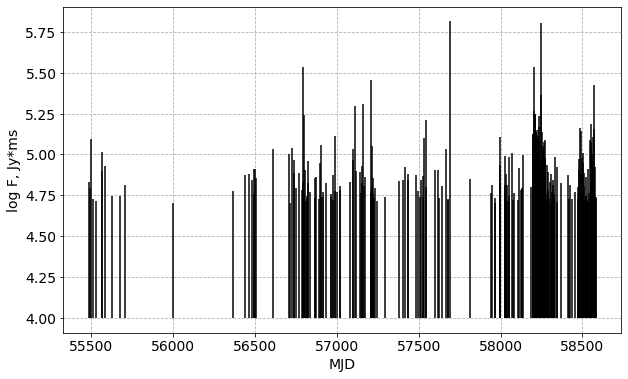

In [330]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log F, Jy*ms')
plt.xlabel('MJD')
plt.vlines(gp_table_cut_E['MJD'], [4], np.log10(gp_table_cut_E['E_fit_func, Jy*ms']))
plt.grid(True, ls='--')
plt.savefig('some_images/fluence_cut_E.eps', format='eps')

### Отрисовка рассеяния

In [331]:
dect_res = {}
bin_size = 30

In [332]:
gp_table.columns

Index(['Date', 'Time start', 'MJD', 'Median, Jy', 'amp of gp, Jy',
       'W50, point', 'W10, point', 'W50_19D_poly, point',
       'W10_19D_poly, point', 'W50_fit_func, point', 'W10_fit_func, point',
       'E_19D_poly, Jy*ms', 'E_fit_func, Jy*ms', 'Tay, ms', 'STD, Jy', 'gp'],
      dtype='object')

In [333]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)

In [334]:
resul_tab_w50 = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'W50_mean',
    'STD',
    'len bin'])

In [335]:
idx = 0
for key in dect_res.keys():
    resul_tab_w50.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key]),
        np.std(dect_res[key]),
        np.size(dect_res[key])
    ]
    idx +=1

In [336]:
resul_tab_w50 = resul_tab_w50.sort_values(by=['№ bin'])

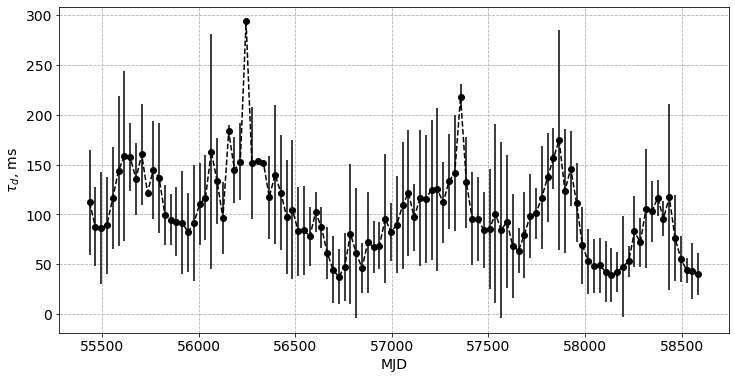

In [337]:
plt.figure(figsize=(12,6))
plt.errorbar(resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'],
             yerr=resul_tab_w50['STD'], color='black', fmt='--o')
plt.ylabel(r'$\tau_d$, ms')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter.eps', format='eps')

## Отрисовка рассеяние + другие графики

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


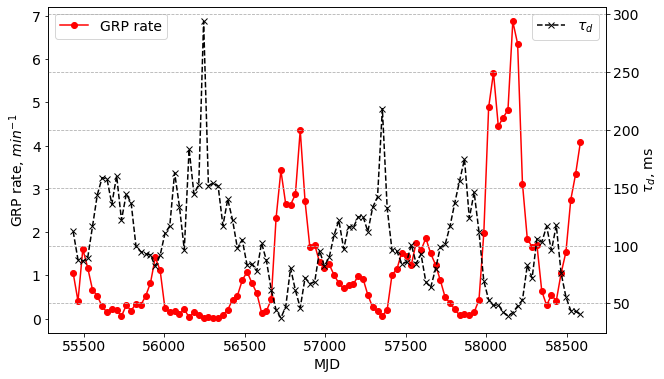

In [338]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax2.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'xb--', color='black', label=r'$\tau_d$')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'$\tau_d$, ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter+gp_rate.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


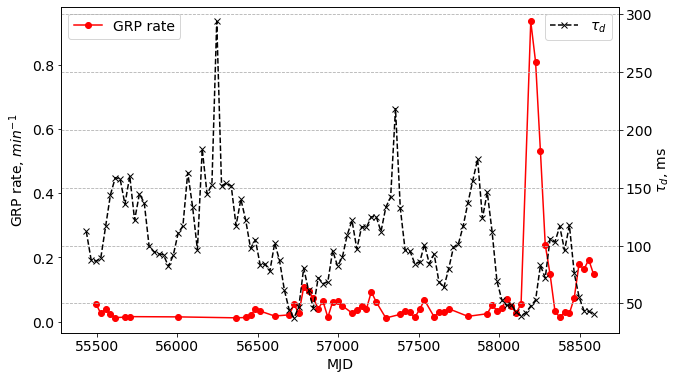

In [339]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GRP rate')
ax2.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'xb--', color='black', label=r'$\tau_d$')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'$\tau_d$, ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter+gp_rate_cut_E.eps', format='eps')

In [340]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
        
resul_tab_cut_E = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'E_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_E.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_E = resul_tab_cut_E.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


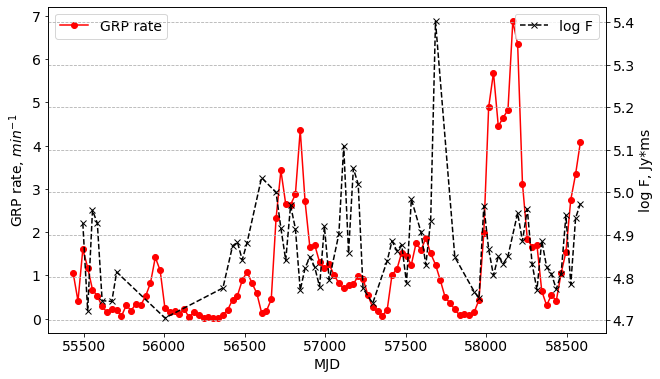

In [341]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean),
         'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate+fluence_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


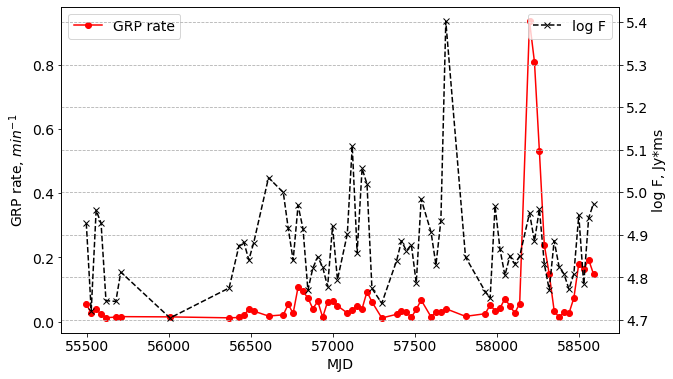

In [342]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean),
         'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E+fluence_mean_bin_30.eps', format='eps')

In [343]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['amp of gp, Jy'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['amp of gp, Jy'])
        
resul_tab_cut_I = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'I_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_I.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_I = resul_tab_cut_I.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


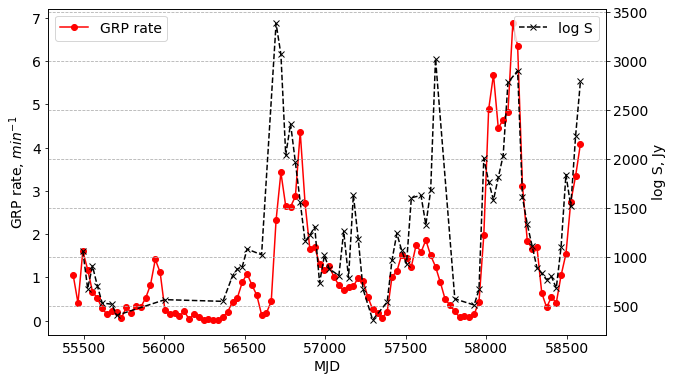

In [344]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_I.MJD_mean, resul_tab_cut_I.I_mean,
         'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate+flux_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


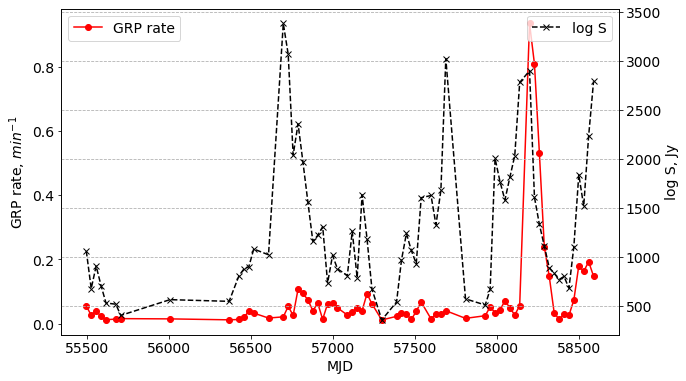

In [345]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_I.MJD_mean, resul_tab_cut_I.I_mean,
         'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E+flux_mean_bin_30.eps', format='eps')

## Отрисовка потока и энергии совместно с рассеянием

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


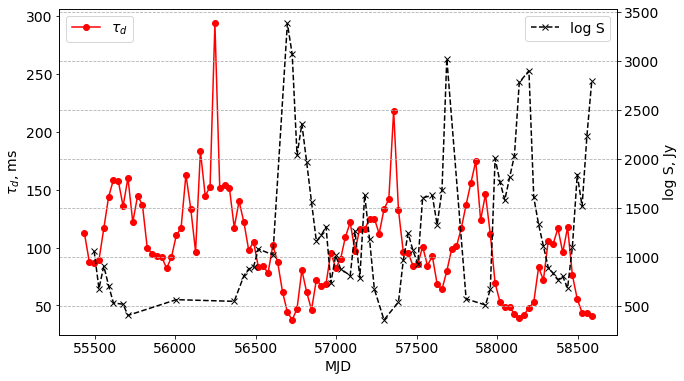

In [346]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'o-', color='red', label=r'$\tau_d$')
ax2.plot(
    resul_tab_cut_I.MJD_mean, resul_tab_cut_I.I_mean, 'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'$\tau_d$, ms')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/t_scatter+flux_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


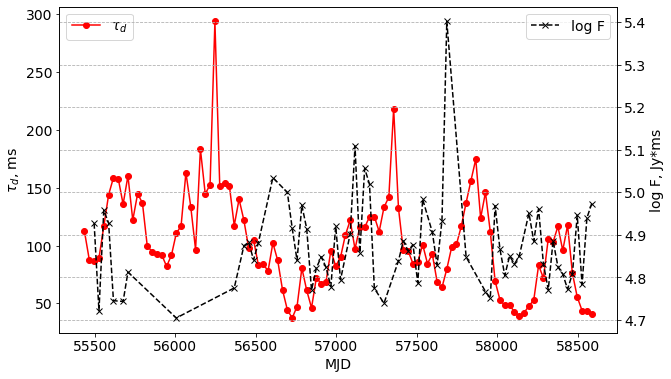

In [347]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'o-', color='red', label=r'$\tau_d$')
ax2.plot(
    resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean), 'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'$\tau_d$, ms')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/t_scatter+fluence_mean_bin_30.eps', format='eps')

In [106]:
resul_tab.to_csv('time_scatterig_bin30_kaz.csv', sep=',', header=True, index=True)

In [107]:
resul_gp.to_csv('gp_rate_bin30_kaz.csv', sep=',', header=True, index=True)